In [1]:
#使用するライブラリのインポート
import codecs
import types
import pandas as pd
import numpy as np
from botocore.client import Config
import ibm_boto3
import datetime as dt
import matplotlib.pyplot as plt
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# APARのcsvファイルを2つ読み込んで、それぞれData Frame df_1,df_2 として保存
with codecs.open("apar_info1.csv", "r", "utf-8", "ignore") as file:
    df_1 = pd.read_table(file, delimiter=",")
    
with codecs.open("apar_info2.csv", "r", "utf-8", "ignore") as file:
    df_2 = pd.read_table(file, delimiter=",")

# 二つのdataframeを合体し、df_aparとして保存
df_apar = pd.concat([df_1, df_2]) 
df_apar.head()

,APAR,STATUS,ISEV,RCOMP,SBDATE,CLOSE CODE,SEV,RREL,RCDATE,HIPER,...,ERROR DESCRIPTION,LOCAL FIX,USERS AFFECTED,PROBLEM DESCRIPTION,RECOMMENDATION,OPTIONAL ERROR DESCRIPTION,PROBLEM CONCLUSION,TEMPORARY FIX,COMMENTS,CIRCUMVENTION
0,OA31527,'CLOSED,'3,'5752SC1BH,'09/12/23,'PER,'3,'R708,'09/12/29,NaN,...,'The customer is seeing a two minute delay bef...,'None\n\n,'All users of HJE7708 with OA20935\napplied\n\n,'SYSGONE complete processing is\ndelayed which...,'\n\n\n,'Due to a lack of an IXZXIXCL invocation for t...,'TYPE/RESTART(WARM) IPL/REQUIRED(YES) CLPA(YES...,'*** * TEMPORARY FIX MAY BE OBTAINED FROM DLL ...,'\n\n\n,'\n\n\n
1,OA31538,'CLOSED,'3,'5655T07CV,'10/01/05,'PER,'2,'R1A0,'10/01/06,NaN,...,'Abend 0C1 in module IRRENV10 after activating...,"'If JC4R1A0 and ptf UA48576 are not accepted, ...",'All users of zSecure Command Verifier v1.10\n\n,'Activating zSecure Command Verifier\nleads to...,NaN,'Having zSecure Command Verifier active leads ...,'Due to the packaging error some extra code se...,NaN,NaN,NaN
2,OA30599,'CLOSED,'2,'5752SC1B4,'09/09/30,'PER,'2,'R750,'09/10/01,'HIPER/Y,...,'In z/OS 1.10 an abend0C4 may occur during dyn...,'If address space does not end and abend0C4's ...,'All HBB7750 and above environments.\n\n,"'ABEND0C4 in IEFAB451, IEFAB4A0 or\nIEFAB421.\n\n",'\n\n\n,'In highly multitasked environments such as DB...,'Allocation's processing is corrected to set u...,'*********\n* HIPER *\n*********\n\n,'\n\n\n,'\n\n\n
3,OA30718,'CLOSED,'4,'5752SC1B4,'09/10/08,'PER,'4,'R740,'09/10/09,'HIPER/Y,...,"'Some tape library environments, including the...",'\n\n\n,'All HBB7740 and above environments which\nuse...,' Performance degradation due to poor\n choice...,'\n\n\n,'When in an SMS managed tape environment that ...,'Tape Allocation is changed to compute device ...,'*********\n* HIPER *\n*********\n\n,'\n\n\n,'\n\n\n
4,OA30827,'CLOSED,'3,'5697ENV00,'09/10/21,'PER,'3,'R54B,'09/10/21,'HIPER/Y,...,'INTERMITTENTLY CNMCALRT WILL GO INTO A LOOP W...,NaN,'All NetView for z/OS V5R4 users of CNMCALRT.\n\n,'Sometimes CNMCALRT will go into a hard\nloop ...,NaN,'CNMCALRT does not clear the DTR area in its a...,'CNMCALRT is being changed to use the task's a...,NaN,NaN,NaN


In [4]:
df_apar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35998 entries, 0 to 18034
Data columns (total 31 columns):
APAR                          35998 non-null object
STATUS                        35998 non-null object
ISEV                          35998 non-null object
RCOMP                         35998 non-null object
SBDATE                        35998 non-null object
CLOSE CODE                    35998 non-null object
SEV                           35998 non-null object
RREL                          35998 non-null object
RCDATE                        35998 non-null object
HIPER                         11724 non-null object
SEC/INT                       15221 non-null object
FCOMP                         35998 non-null object
CLDATE                        35998 non-null object
PE                            2809 non-null object
PFREL                         35998 non-null object
FAILURE KEYWORD               35998 non-null object
MODULES/MACROS                35995 non-null object
APPLICAB

In [5]:
df_apar.columns

Index(['APAR', 'STATUS', 'ISEV', 'RCOMP', 'SBDATE', 'CLOSE CODE', 'SEV',
       'RREL', 'RCDATE', 'HIPER', 'SEC/INT', 'FCOMP', 'CLDATE', 'PE', 'PFREL',
       'FAILURE KEYWORD', 'MODULES/MACROS', 'APPLICABLE LVL', 'function?',
       'version?', 'ABSTRACT', 'ERROR DESCRIPTION', 'LOCAL FIX',
       'USERS AFFECTED', 'PROBLEM DESCRIPTION', 'RECOMMENDATION',
       'OPTIONAL ERROR DESCRIPTION', 'PROBLEM CONCLUSION', 'TEMPORARY FIX',
       'COMMENTS', 'CIRCUMVENTION'],
      dtype='object')

In [6]:
#APAR名の列をインデックスにする
df_apar.set_index('APAR',drop=True,inplace=True)

In [7]:
#日付のフォーマットをDataFrameのフォーマットに変換
df_apar["SBDATE"] = pd.to_datetime(df_apar["SBDATE"],format="'%y/%m/%d")
df_apar["RCDATE"] = pd.to_datetime(df_apar["RCDATE"],format="'%y/%m/%d")
df_apar["CLDATE"] = pd.to_datetime(df_apar["CLDATE"],format="'%y/%m/%d")

In [8]:
df_apar[['SBDATE','RCDATE','CLDATE']].head()

,SBDATE,RCDATE,CLDATE
APAR,,,
OA31527,2009-12-23,2009-12-29,2010-01-08
OA31538,2010-01-05,2010-01-06,2010-01-13
OA30599,2009-09-30,2009-10-01,2010-01-04
OA30718,2009-10-08,2009-10-09,2010-01-14
OA30827,2009-10-21,2009-10-21,2010-01-13


In [9]:
#PE,HIPER列をカウント
print(df_apar['PE'].value_counts())
print(df_apar['HIPER'].value_counts())

'PE/Y    2809
Name: PE, dtype: int64
'HIPER/Y    11724
Name: HIPER, dtype: int64


In [10]:
#PE、HIPERの列について、PE,HIPERに該当する値を1に変換する
df_apar['PE'] = df_apar['PE'].str.replace("'PE/Y", "1")
df_apar['HIPER'] = df_apar['HIPER'].str.replace("'HIPER/Y", "1")

#PE、HIPERの列について、値が入っていないNaNを、0に変換する
df_apar['PE'] = df_apar['PE'].fillna(0)
df_apar['HIPER'] = df_apar['HIPER'].fillna(0)

#PE、HIPERの列について、0,1 の値をboolean形式に変換する
df_apar['PE'] = df_apar['PE'].astype(bool)
df_apar['HIPER'] = df_apar['HIPER'].astype(bool)

In [11]:
df_apar['COMMENTS'] = df_apar['COMMENTS'].fillna('none')
#PEを起こしたPTFを検出。comment欄に「IN ERROR. SEE APAR」が記載されている列をPE_involve=Trueとし、無い場合はFalseとする。
df_apar['PE_involve'] = False
#df_apar.loc[df_apar['COMMENTS'].str.contains('IN ERROR. SEE APAR'),'PE_involve'] = True
#df_apar.loc[df_apar['COMMENTS'].str.contains('IN ERROR.SEE APAR'),'PE_involve'] = True
df_apar.loc[df_apar['COMMENTS'].str.contains(r"PE\d+/\d+/\d+"),'PE_involve'] = True

In [12]:
#PE_involveの件数を確認
a = len(df_apar[df_apar['PE_involve']==True])
b = len(df_apar)
print('PE_involveの数:',a)
print('PE_involveの割合(%):',(a/b)*100)

PE_involveの数: 403
PE_involveの割合(%): 1.1195066392577364


In [13]:
df_apar[['PE','HIPER','PE_involve']].head()

,PE,HIPER,PE_involve
APAR,,,
OA31527,False,False,False
OA31538,True,False,False
OA30599,False,True,False
OA30718,False,True,False
OA30827,False,True,False


In [14]:
# 修正までの日数を列に追加。（列名を要確認）
df_apar['days_to_aparclose'] = df_apar['CLDATE']-df_apar['SBDATE']
df_apar['days_to_aparclose'] = df_apar['days_to_aparclose'].dt.days

In [15]:
df_apar['days_to_aparclose'].describe()

count    35998.000000
mean        68.494861
std         85.888812
min          0.000000
25%         20.000000
50%         44.000000
75%         84.000000
max       1535.000000
Name: days_to_aparclose, dtype: float64

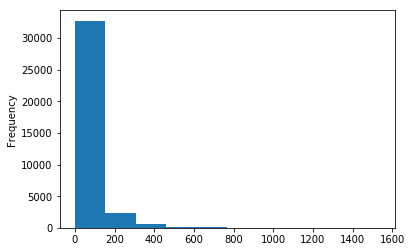

In [16]:
#修正までの日数をプロットしてみる
df_apar['days_to_aparclose'].plot.hist()

In [17]:
#SEVの列の' を削除。それぞれに対応する変数列を追加
df_apar['SEV'] = df_apar['SEV'].str.replace("'", "")
df_apar = pd.get_dummies(df_apar, columns=["SEV"])

In [18]:
#修正までに100日以上掛かっているAPARのPE率を算出
a = len(df_apar[df_apar['days_to_aparclose'] > 100])
print('修正までに100日以上掛かった件数:',a)
b = len(df_apar[(df_apar['days_to_aparclose'] > 100)&(df_apar['PE_involve'] == True)])
print('修正までに100日以上掛かった物のうち、PEになった数:',b)
print('修正までに100日以上掛かった物のうち、PEになった割合(%):',(b/a)*100)

#HIPERで、修正までに100日以上掛かっているAPARのPE率を算出
c = len(df_apar[(df_apar['days_to_aparclose'] > 100)&(df_apar['HIPER'] == True)])
print('HIPERで修正までに100日以上掛かった件数:',c)
d = len(df_apar[(df_apar['days_to_aparclose'] > 100)&(df_apar['PE_involve'] == True)&(df_apar['HIPER'] == True)])
print('HIPERで修正までに100日以上掛かった物のうち、PEになった数:',d)
print('HIPERで修正までに100日以上掛かった物のうち、PEになった割合(%):',(d/c)*100)

修正までに100日以上掛かった件数: 6719
修正までに100日以上掛かった物のうち、PEになった数: 132
修正までに100日以上掛かった物のうち、PEになった割合(%): 1.9645780622116389
HIPERで修正までに100日以上掛かった件数: 2091
HIPERで修正までに100日以上掛かった物のうち、PEになった数: 20
HIPERで修正までに100日以上掛かった物のうち、PEになった割合(%): 0.9564801530368245


In [19]:
#PE修正がさらにPEになる率を確認
a = len(df_apar[df_apar['PE']==True]) #PE修正の数
b = len(df_apar[(df_apar['PE']==True) & (df_apar['PE_involve']==True)]) #PE修正がPEになった数
print('PE修正の数:',a)
print('PE修正がPEになった数:',b)
print('PE修正がPEになった割合(%):',(b/a)*100)

PE修正の数: 2809
PE修正がPEになった数: 72
PE修正がPEになった割合(%): 2.5631897472410112


In [20]:
#COMMENTS列から"PExx/xx/xx" の日付フォーマットの文字列を検索し、PEが発生した日付："PE_date"として列を追加
#df_apar['PE_date'] = df_apar['COMMENTS'].str.findall(r"PE\d+/\d+/\d+")
df_apar['PE_date'] = df_apar['COMMENTS'].str.findall(r"PE\d+/\d+/\d+")

In [21]:
df_apar['FAILURE KEYWORD'].value_counts()

'IN INCORROUT       14118
'AB ABEND            7251
'AB ABEND0C4         1401
'PR PERFM             982
'NF NEW FUNCTION      926
'NF NEWFUNCTION       760
'AB ABEND04E          650
'LP LOOP              524
'MS MSG               482
'AB ABENDS0C4         385
'WS WAIT              377
'NF NEWFUNCT          304
'IN IN                264
'IN INCORRECT         218
'IN INCORR            205
'MS MESSAGE           198
'AB INCORROUT         192
'NF New Function      173
'NF INCORROUT         171
'AB ABENDxxx          171
'NF NEWFUNC           151
'MI MSG               135
'PR PERFORMANCE       109
'NF FUNCTION          105
'IN INCOROUT          104
'NF NF                100
'AB ABEND0C1          100
'AB MSG                94
'IN ABEND              93
'AB ABEND878           91
                    ...  
'WS WAIT040             1
'MS MSGDSNV508I         1
'AB SRCME0121           1
'MS RC01000010          1
'MS MSGaxr0111i         1
'MS MSGIEF086I          1
'MS MSGOBRTMP           1
'AB ABENDS13

In [22]:
#FAILURE KEYWORDの列の文字列の最初から3文字目までを抜粋し、FAILURE_KEY列として追加
df_apar['FAILURE_KEY'] = df_apar['FAILURE KEYWORD'].str[0:3]

In [23]:
df_apar['FAILURE_KEY'].value_counts()

'IN    15602
'AB    12339
'NF     3105
'MS     1843
'PR     1165
'LP      577
'WS      479
'PF      308
'MI      148
'UN      117
'UR      102
'DD       78
'AI       69
'AE       37
'HL       24
'MC        4
'IG        1
Name: FAILURE_KEY, dtype: int64

In [24]:
#FAILURE KEYWORD列の上位5つについて、PE数を確認
a = len(df_apar[df_apar['FAILURE_KEY'] == "'IN"])
b = len(df_apar[(df_apar['FAILURE_KEY'] == "'IN")&(df_apar['PE_involve'] == True)])
print('FAILURE KEYWORD列がINの数:',a)
print('PE_involve数:',b)
print('PE_involveの割合(%):',(b/a)*100)

a = len(df_apar[df_apar['FAILURE_KEY'] == "'AB"])
b = len(df_apar[(df_apar['FAILURE_KEY'] == "'AB")&(df_apar['PE_involve'] == True)])
print('FAILURE KEYWORD列がABの数:',a)
print('PE_involve数:',b)
print('PE_involveの割合(%):',(b/a)*100)

a = len(df_apar[df_apar['FAILURE_KEY'] == "'NF"])
b = len(df_apar[(df_apar['FAILURE_KEY'] == "'NF")&(df_apar['PE_involve'] == True)])
print('FAILURE KEYWORD列がNFの数:',a)
print('PE_involve数:',b)
print('PE_involveの割合(%):',(b/a)*100)

a = len(df_apar[df_apar['FAILURE_KEY'] == "'MS"])
b = len(df_apar[(df_apar['FAILURE_KEY'] == "'MS")&(df_apar['PE_involve'] == True)])
print('FAILURE KEYWORD列がMSの数:',a)
print('PE_involve数:',b)
print('PE_involveの割合(%):',(b/a)*100)

a = len(df_apar[df_apar['FAILURE_KEY'] == "'PR"])
b = len(df_apar[(df_apar['FAILURE_KEY'] == "'PR")&(df_apar['PE_involve'] == True)])
print('FAILURE KEYWORD列がPRの数:',a)
print('PE_involve数:',b)
print('PE_involveの割合(%):',(b/a)*100)

FAILURE KEYWORD列がINの数: 15602
PE_involve数: 162
PE_involveの割合(%): 1.0383284194334061
FAILURE KEYWORD列がABの数: 12339
PE_involve数: 87
PE_involveの割合(%): 0.7050814490639437
FAILURE KEYWORD列がNFの数: 3105
PE_involve数: 108
PE_involveの割合(%): 3.4782608695652173
FAILURE KEYWORD列がMSの数: 1843
PE_involve数: 15
PE_involveの割合(%): 0.8138903960933261
FAILURE KEYWORD列がPRの数: 1165
PE_involve数: 13
PE_involveの割合(%): 1.1158798283261802


・APARがopenされてから、PEとして認識されるまでの期間を検証　ネタ元：小沢さん

PExx/xx/xx
AExx/xx/xx の違いは？

In [25]:
pe_involve = df_apar[df_apar['PE_involve']==True]

pe_date = pe_involve['PE_date'].tolist()

In [26]:
dates = [[x.replace('PE','') for x in l] for l in pe_date]

In [27]:
open_date = [min(l) for l in dates]

In [28]:
pe_involve['PE_date'] = pd.to_datetime(open_date,format="%y/%m/%d")

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
pe_involve['days_to_pe'] = pe_involve['PE_date']-pe_involve['CLDATE']
pe_involve['days_to_pe'] = pe_involve['days_to_pe'].dt.days

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [30]:
pe_involve['days_to_pe'].describe()

count    403.000000
mean      69.014888
std       89.373106
min      -40.000000
25%       14.000000
50%       33.000000
75%       86.000000
max      433.000000
Name: days_to_pe, dtype: float64

Text(0,0.5,'Number of PE')

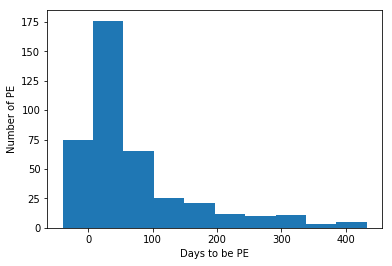

In [31]:
pe_involve['days_to_pe'].plot.hist()
plt.xlabel('Days to be PE')
plt.ylabel('Number of PE')

In [32]:
pe_involve[pe_involve['days_to_pe'] < 1].sort_values(by=['days_to_pe'])[['SBDATE','RCDATE','CLDATE','PE_date']]

,SBDATE,RCDATE,CLDATE,PE_date
APAR,,,,
OA43054,2013-08-08,2013-08-14,2013-11-21,2013-10-12
PI86681,2017-08-31,2017-08-31,2017-09-28,2017-08-31
PI82971,2017-06-12,2017-06-12,2017-07-06,2017-06-12
PI70458,2016-10-10,2016-10-10,2016-10-31,2016-10-10
PI67770,2016-08-18,2016-08-18,2016-09-12,2016-08-23
PI81491,2017-05-11,2017-05-12,2017-06-01,2017-05-12
PH03933,2018-10-10,2018-10-10,2018-10-25,2018-10-10
PI63358,2016-05-31,2016-05-31,2016-06-15,2016-05-31
PI77686,2017-03-06,2017-03-06,2017-03-20,2017-03-06


In [33]:
#pe_involve.loc['OA43054']['COMMENTS']

In [34]:
#pe_involve.loc['PI98784']

・RCOMPのコンポーネント毎のGAからのPE数を時系列化
->先に全APAR情報についてRCOMPが多い順にソートして、一番多い製品に関してRREL毎にGA日からのPE日数を見る

上位5つのものでそれぞれ5つdfを作って、GA日を設定して、発生日をbinにしてPE_dateをplotしていく？



In [35]:
#pe_involve['RCOMP'].value_counts().head()
df_apar['RCOMP'].value_counts().head()

'5740XYR00    8568
'5635A0400    1486
'5635A0300    1186
'5655R3600     944
'5655Y0400     937
Name: RCOMP, dtype: int64

In [36]:
#pe_involve[pe_involve['RCOMP']== "'5655X0100"][['RCOMP','RREL']]
pe_involve[pe_involve['RCOMP']== "'5740XYR00"]['RREL'].value_counts()

'R910    6
'RC10    4
'RA10    4
'R810    3
'RB10    1
Name: RREL, dtype: int64

In [37]:
#pe_involve[pe_involve['RCOMP']== "'5740XYR00"][['RCOMP','RREL']]
pe_involve[pe_involve['RCOMP']== "'5635A0400"]['RREL'].value_counts()

'R300    11
'R302     1
Name: RREL, dtype: int64

In [38]:
#pe_involve[pe_involve['RCOMP']== "'694235B00"][['RCOMP','RREL']]
pe_involve[pe_involve['RCOMP']== "'5635A0300"]['RREL'].value_counts()

'R200    14
'R202     2
Name: RREL, dtype: int64

In [39]:
pe_involve[pe_involve['RCOMP']== "'5655R3600"]['RREL'].value_counts()

'R010    7
'R100    6
Name: RREL, dtype: int64

In [40]:
pe_involve[pe_involve['RCOMP']== "'5655Y0400"]['RREL'].value_counts()

'R800    7
'R900    1
'R00M    1
'R100    1
Name: RREL, dtype: int64